In [18]:
from keras.models import clone_model
from kerassurgeon.operations import delete_layer, insert_layer
from models.VLAE import VLAE

vlae_fm1 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=1,
                z_dims=[2,2,2])
vlae_fm1.load_weights("/Users/leo/Downloads/mnist_vlae_factor_1.h5")

vlae_fm2 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=2,
                z_dims=[2,2,2])
vlae_fm2.load_weights("/Users/leo/Downloads/mnist_vlae_factor_2.h5")

vlae_fm3 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=3,
                z_dims=[2,2,2])
vlae_fm3.load_weights("/Users/leo/Downloads/mnist_vlae_factor_3.h5")

In [40]:
import keras
import numpy as np
from typing import List
from keras import backend as K
class FewActiveLayer(keras.layers.Layer):
    def __init__(self, active_idxs: List[int], mean_activities: np.ndarray, **kwargs):
        super(FewActiveLayer, self).__init__(**kwargs)
        self.mean_activities = mean_activities
        self.active_idxs = active_idxs
        self.inactive_idxs = np.setdiff1d(np.arange(0, mean_activities.shape[-1]), self.active_idxs)

    def get_config(self):
        return {'n_dft':32,'class_name':'Conv2D'}


    def call(self, inputs):
        print("BUILDING LAYER")
        print(f"INPUTS: {inputs}")
        print(f"MEAN ACTIVITY: {mean_activities.shape}")

        output_list = []
        for feature_map_idx in range(self.mean_activities.shape[-1]):
            if feature_map_idx in self.active_idxs:
                output_list.append(inputs[:,:,:,feature_map_idx])
            else:
                output_list.append(K.variable(np.stack([mean_activities[:,:,feature_map_idx]]*32)))
        res = K.stack(output_list, axis=-1)
        print(f"RESULT: {res}")
        print("----------------")
        return res

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inference_0_conv2d_0 (Conv2D)   (None, 14, 14, 64)   1664        input_16[0][0]                   
__________________________________________________________________________________________________
inference_0_relu_0 (ReLU)       (None, 14, 14, 64)   0           inference_0_conv2d_0[0][0]       
__________________________________________________________________________________________________
inference_1_conv2d_0 (Conv2D)   (None, 7, 7, 64)     36928       inference_0_relu_0[0][0]         
____________________________________________________________________________________________

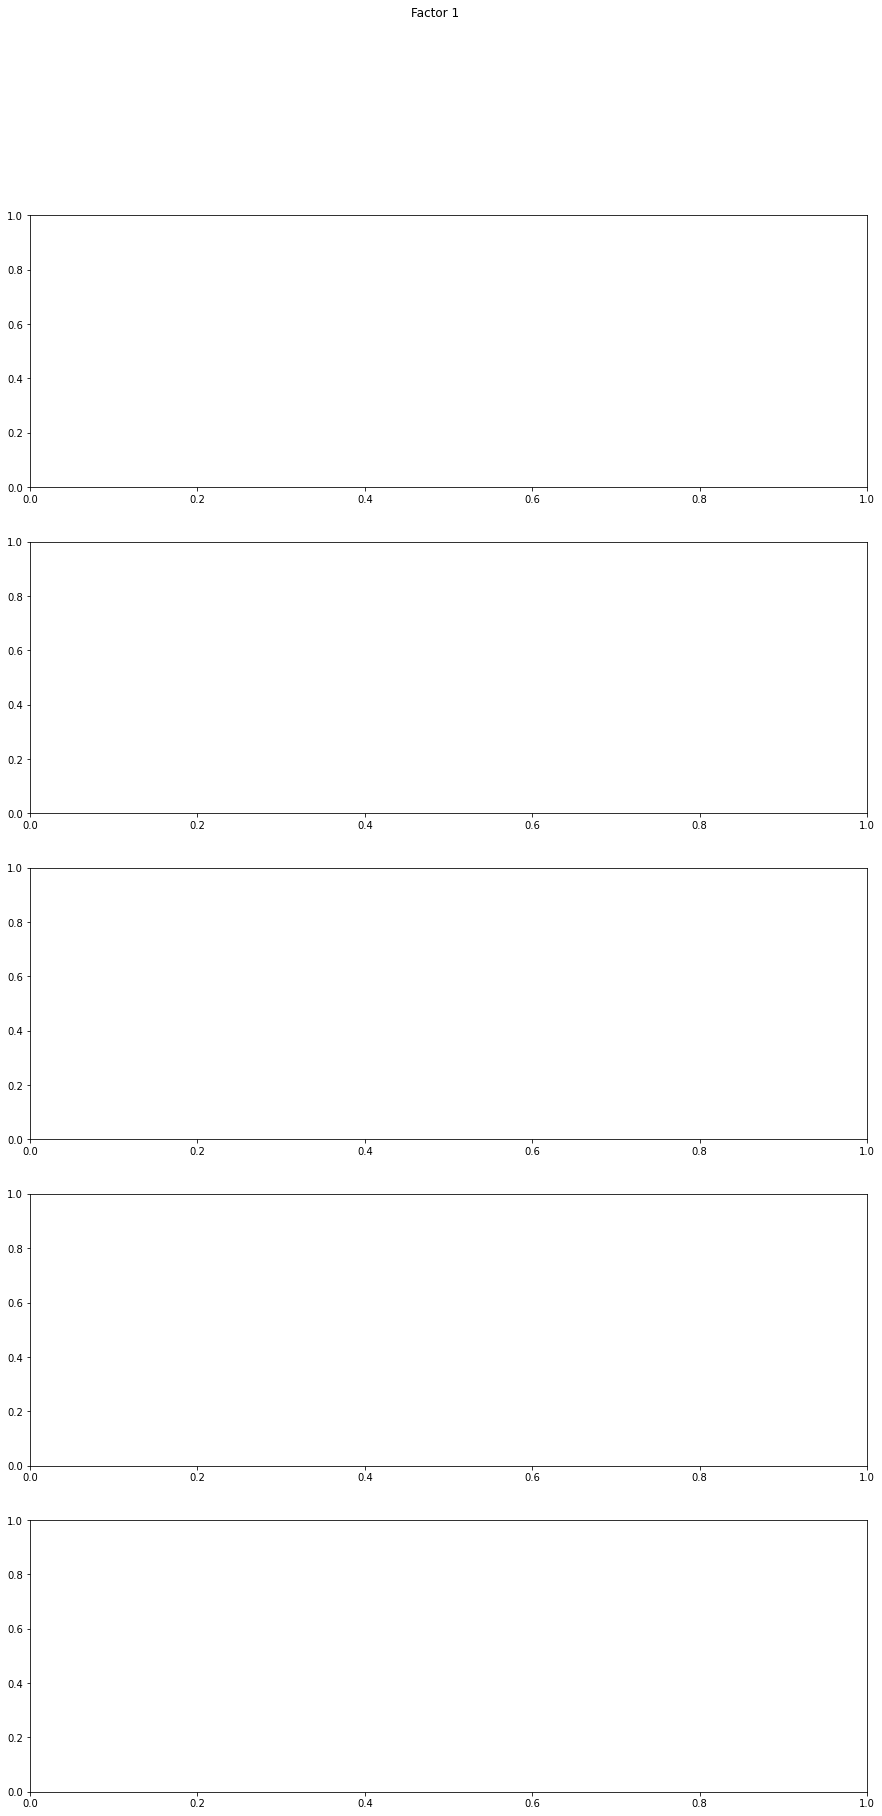

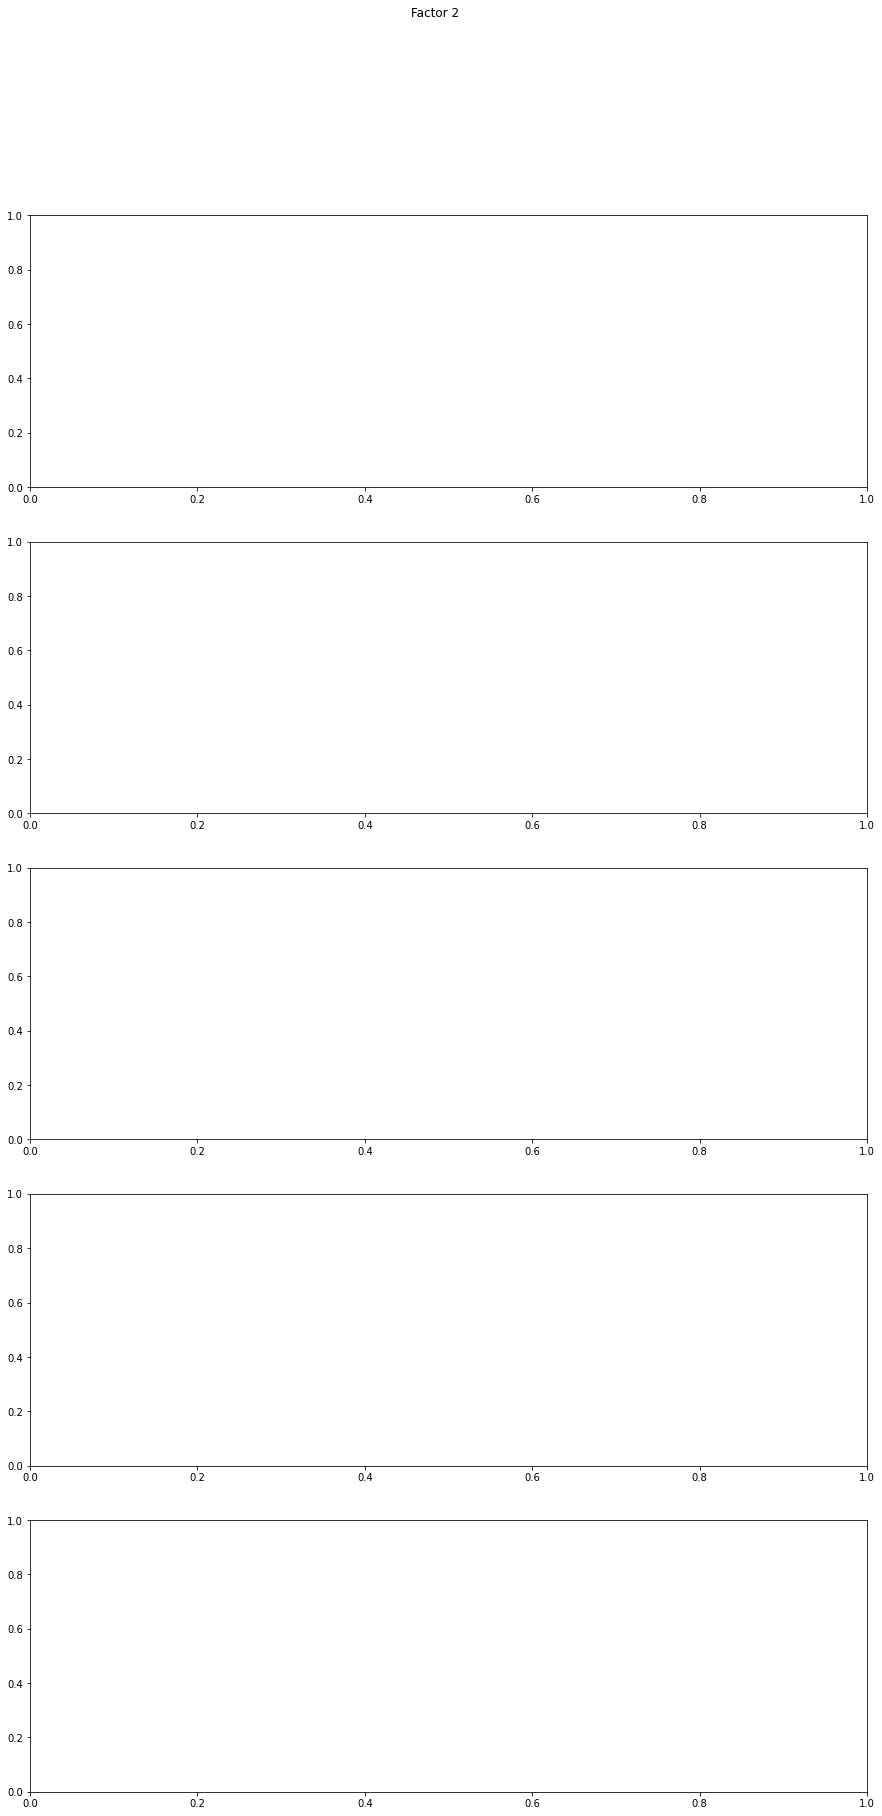

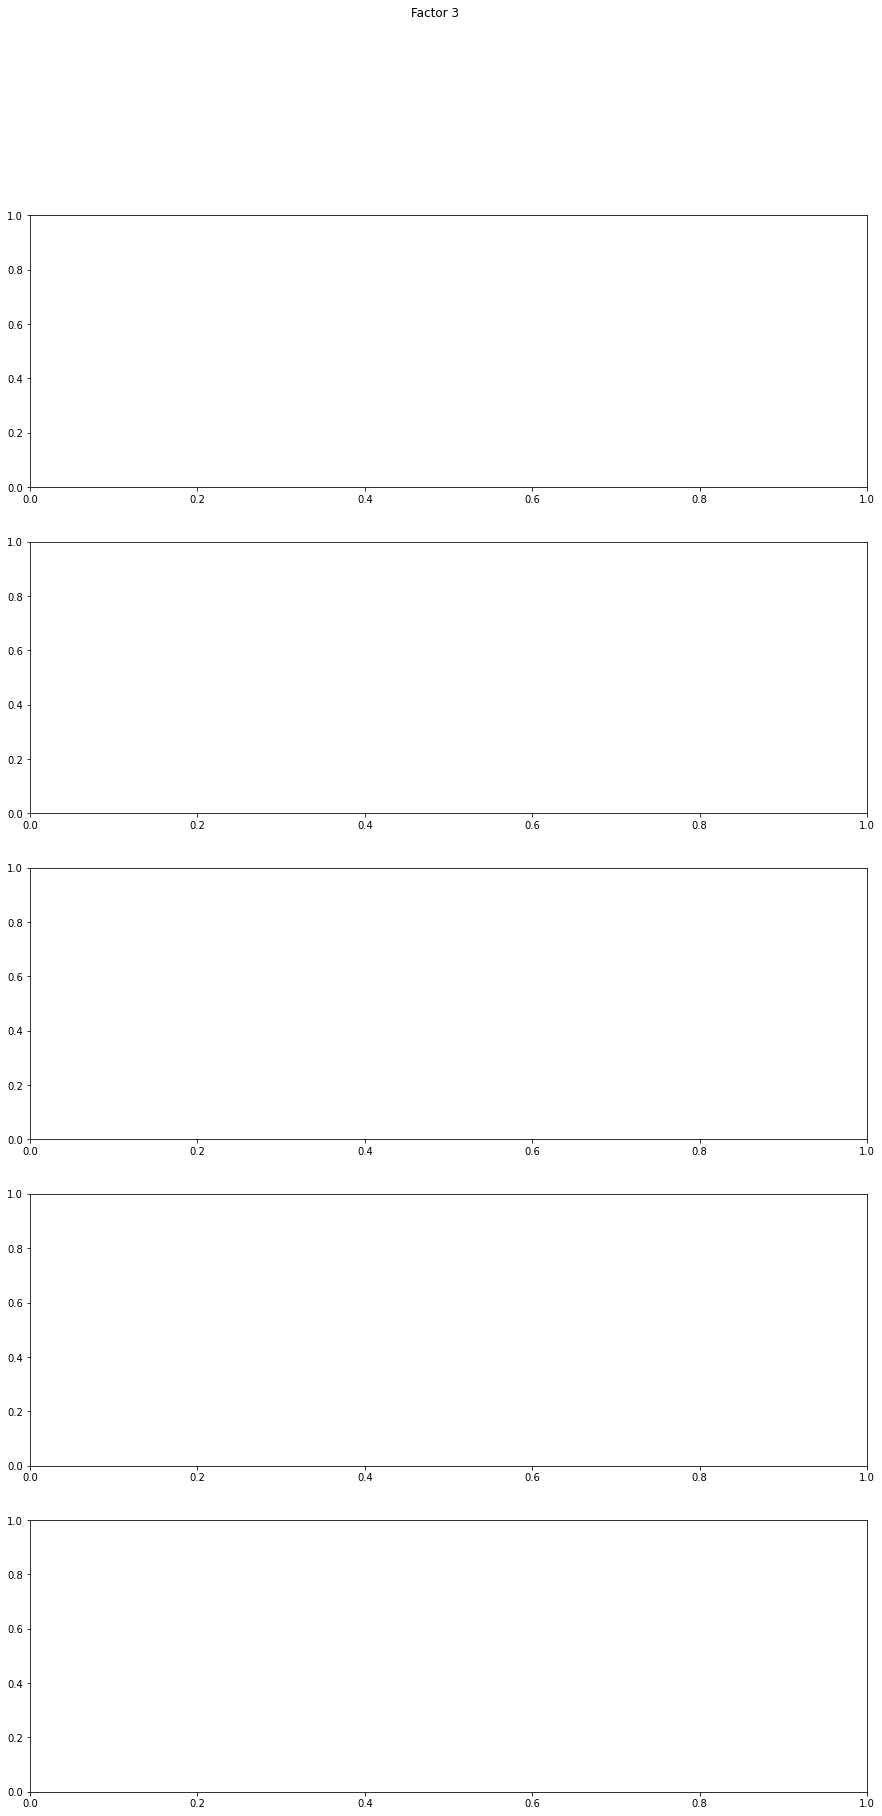

In [127]:
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import Model
from keras.layers import Input, Conv2D, Lambda, Dense, ReLU
from utils.vae_utils import sampling

(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

def top_argmax(arr, n):
    arr = np.copy(arr)
    arr = arr.flatten()
    maxs = []
    for i in range(min(n, len(arr))):
        max = np.argmax(arr)
        maxs.append(max)
        arr[max] = -np.inf
    return maxs

new_encoders = {}

for name, model in [("Factor 1",vlae_fm1), ("Factor 2",vlae_fm2), ("Factor 3",vlae_fm3)]:
    encoder = clone_model(model.encoder)
    encoder.summary()

    conv_layers = [l for l in encoder.layers if isinstance(l, Conv2D)]

    multi_output_model = Model(encoder.inputs, [l.output for l in conv_layers])
    
    preds = multi_output_model.predict(np.expand_dims(x_val / 255.0, -1))
    
    fig, axs = plt.subplots(ncols = 1, nrows = len(conv_layers)-1, figsize = (15,5*len(conv_layers)-1))
    fig.suptitle(name)

    x = l0 = i0 = None
    num_conv_layers = 0
    for i, layer in enumerate(encoder.layers):
        print(i)
        if i == 0:
            l0 = i0 = x = inp = Input(shape=layer.batch_input_shape[1:])
        else:
            if isinstance(layer, Lambda):
                if 'z_1' in layer.name:
                    y = Lambda(sampling, name=layer.name)([mu_1, log_var_1])
                elif 'z_2' in layer.name:
                    y = Lambda(sampling, name=layer.name)([mu_2, log_var_2])
                else:
                    y = Lambda(sampling, name=layer.name)([mu_3, log_var_3])
            else:
                y = layer.__class__(**layer.get_config())
            print(layer.get_config())
            #y.set_weights(layer.get_weights())
            if 'ladder_0' in layer.name or 'mu_1' in layer.name or 'log_var_1' in layer.name or 'z_1' in layer.name:
                if not 'z_1' in layer.name and not 'mu_1' in layer.name and not 'log_var_1' in layer.name:
                    x = l0 = y(l0)
                    if isinstance(layer, Conv2D):
                        activies = np.mean(preds[num_conv_layers], axis=(1,2))
                        num_fms = activies.shape[-1]
                        top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                        mean_activities = np.mean(preds[num_conv_layers], axis=0)
                        print(layer.output_shape)
                        x = l0 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                        num_conv_layers+=1
                elif 'mu_1' in layer.name:
                    mu_1 = y(l0)
                elif 'log_var_1' in layer.name:
                    log_var_1 = y(l0)
                else:
                    x = l0 = y
            else:
                if 'inference_0' in layer.name:
                    x = l1 = i1 = i0 = y(i0)
                    if isinstance(layer, Conv2D):
                        activies = np.mean(preds[num_conv_layers], axis=(1,2))
                        num_fms = activies.shape[-1]
                        top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                        mean_activities = np.mean(preds[num_conv_layers], axis=0)
                        print(layer.output_shape)
                        x = l1 = i1 = i0 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                        num_conv_layers+=1
                elif 'ladder_1' in layer.name or 'mu_2' in layer.name or 'log_var_2' in layer.name or 'z_2' in layer.name:
                    if not 'z_2' in layer.name and not 'mu_2' in layer.name and not 'log_var_2' in layer.name:
                        x = l1 = y(l1)
                        if isinstance(layer, Conv2D):
                            activies = np.mean(preds[num_conv_layers], axis=(1,2))
                            num_fms = activies.shape[-1]
                            top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                            mean_activities = np.mean(preds[num_conv_layers], axis=0)
                            print(layer.output_shape)
                            x = l1 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                            num_conv_layers+=1
                    elif 'mu_2' in layer.name:
                        mu_2 = y(l1)
                    elif 'log_var_2' in layer.name:
                        log_var_2 = y(l1)
                    else:
                        x = l1 = y

                else:
                    if not 'z_3' in layer.name and not 'mu_3' in layer.name and not 'log_var_3' in layer.name:
                        x = i1 = y(i1)
                        if isinstance(layer, Conv2D):
                            activies = np.mean(preds[num_conv_layers], axis=(1,2))
                            num_fms = activies.shape[-1]
                            top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                            mean_activities = np.mean(preds[num_conv_layers], axis=0)
                            print(layer.output_shape)
                            x = i1 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                            num_conv_layers+=1
                    elif 'mu_3' in layer.name:
                        mu_3 = y(i1)
                    elif 'log_var_3' in layer.name:
                        log_var_3 = y(i1)
                    else:
                        x = i1 = y



    new_encoder = Model(inp, [l0, l1, i1])
    new_encoders[f"{name} - Inactive Maps"] = new_encoder

    for layer in new_encoder.layers:
        if isinstance(layer, (Conv2D, Dense, ReLU)):
            layer.set_weights(encoder.get_layer(name = layer.name).get_weights())

In [95]:
len(x_val)

10000

In [97]:
preds = vlae_fm3.decoder.predict(new_encoder.predict(np.expand_dims(x_train[:128]/255.0,-1), batch_size=32))


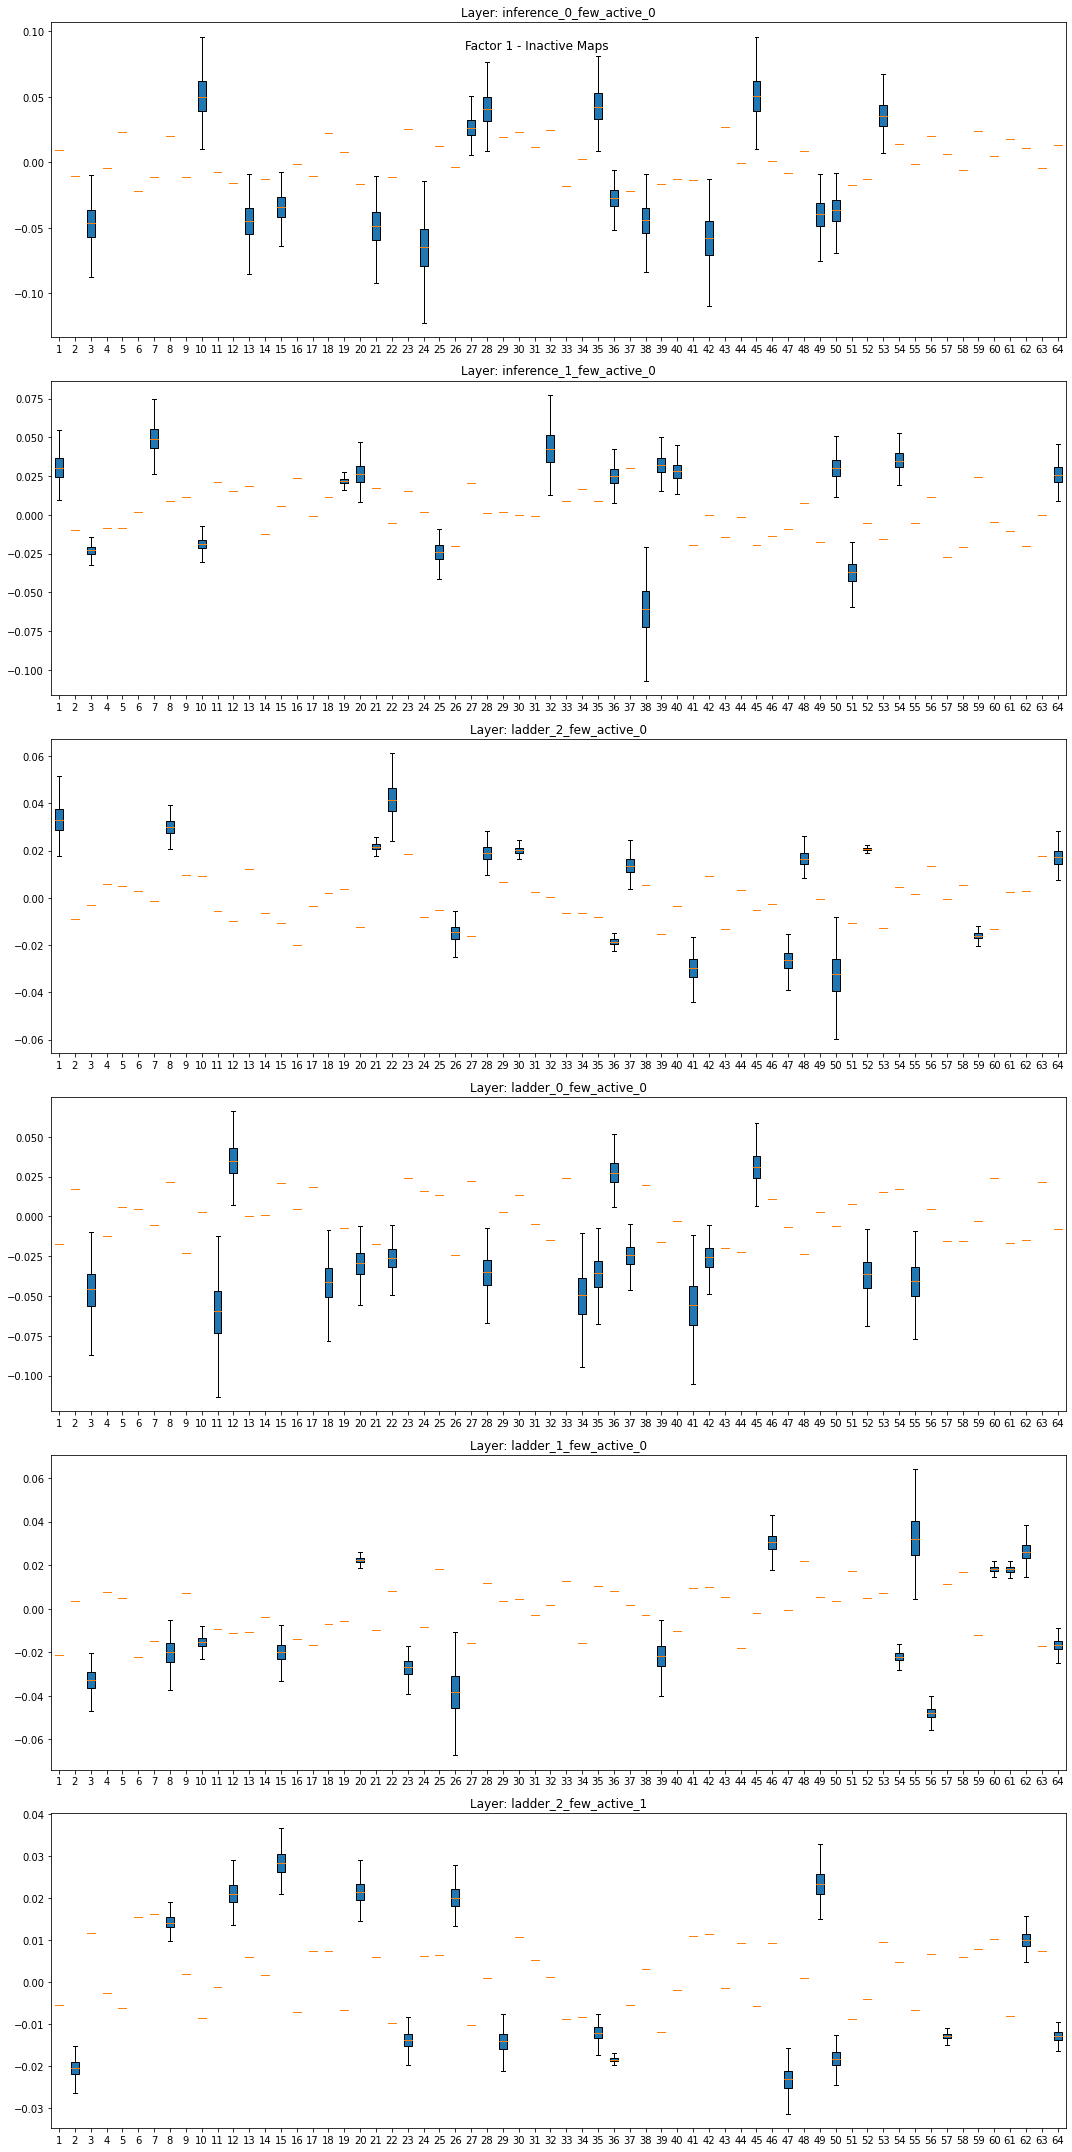

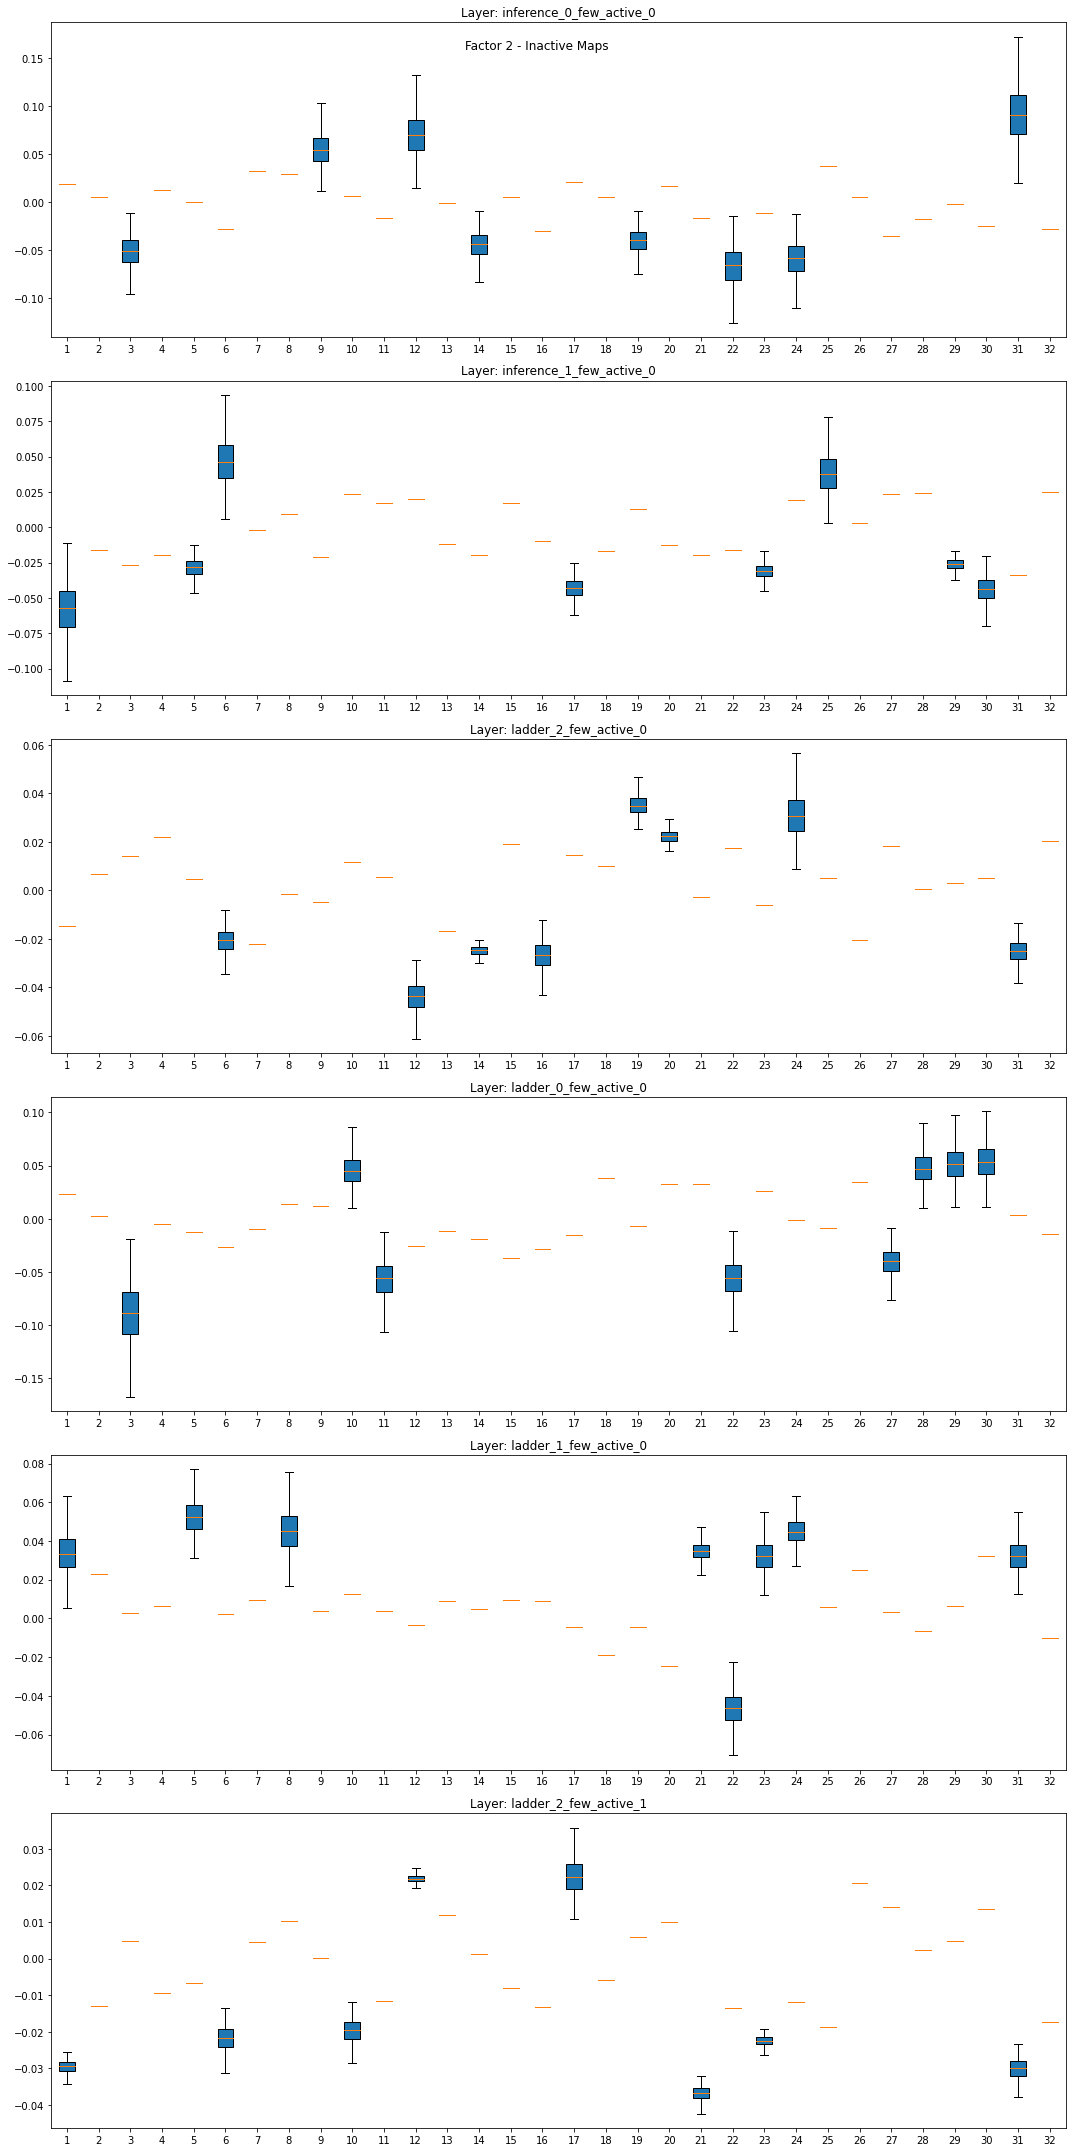

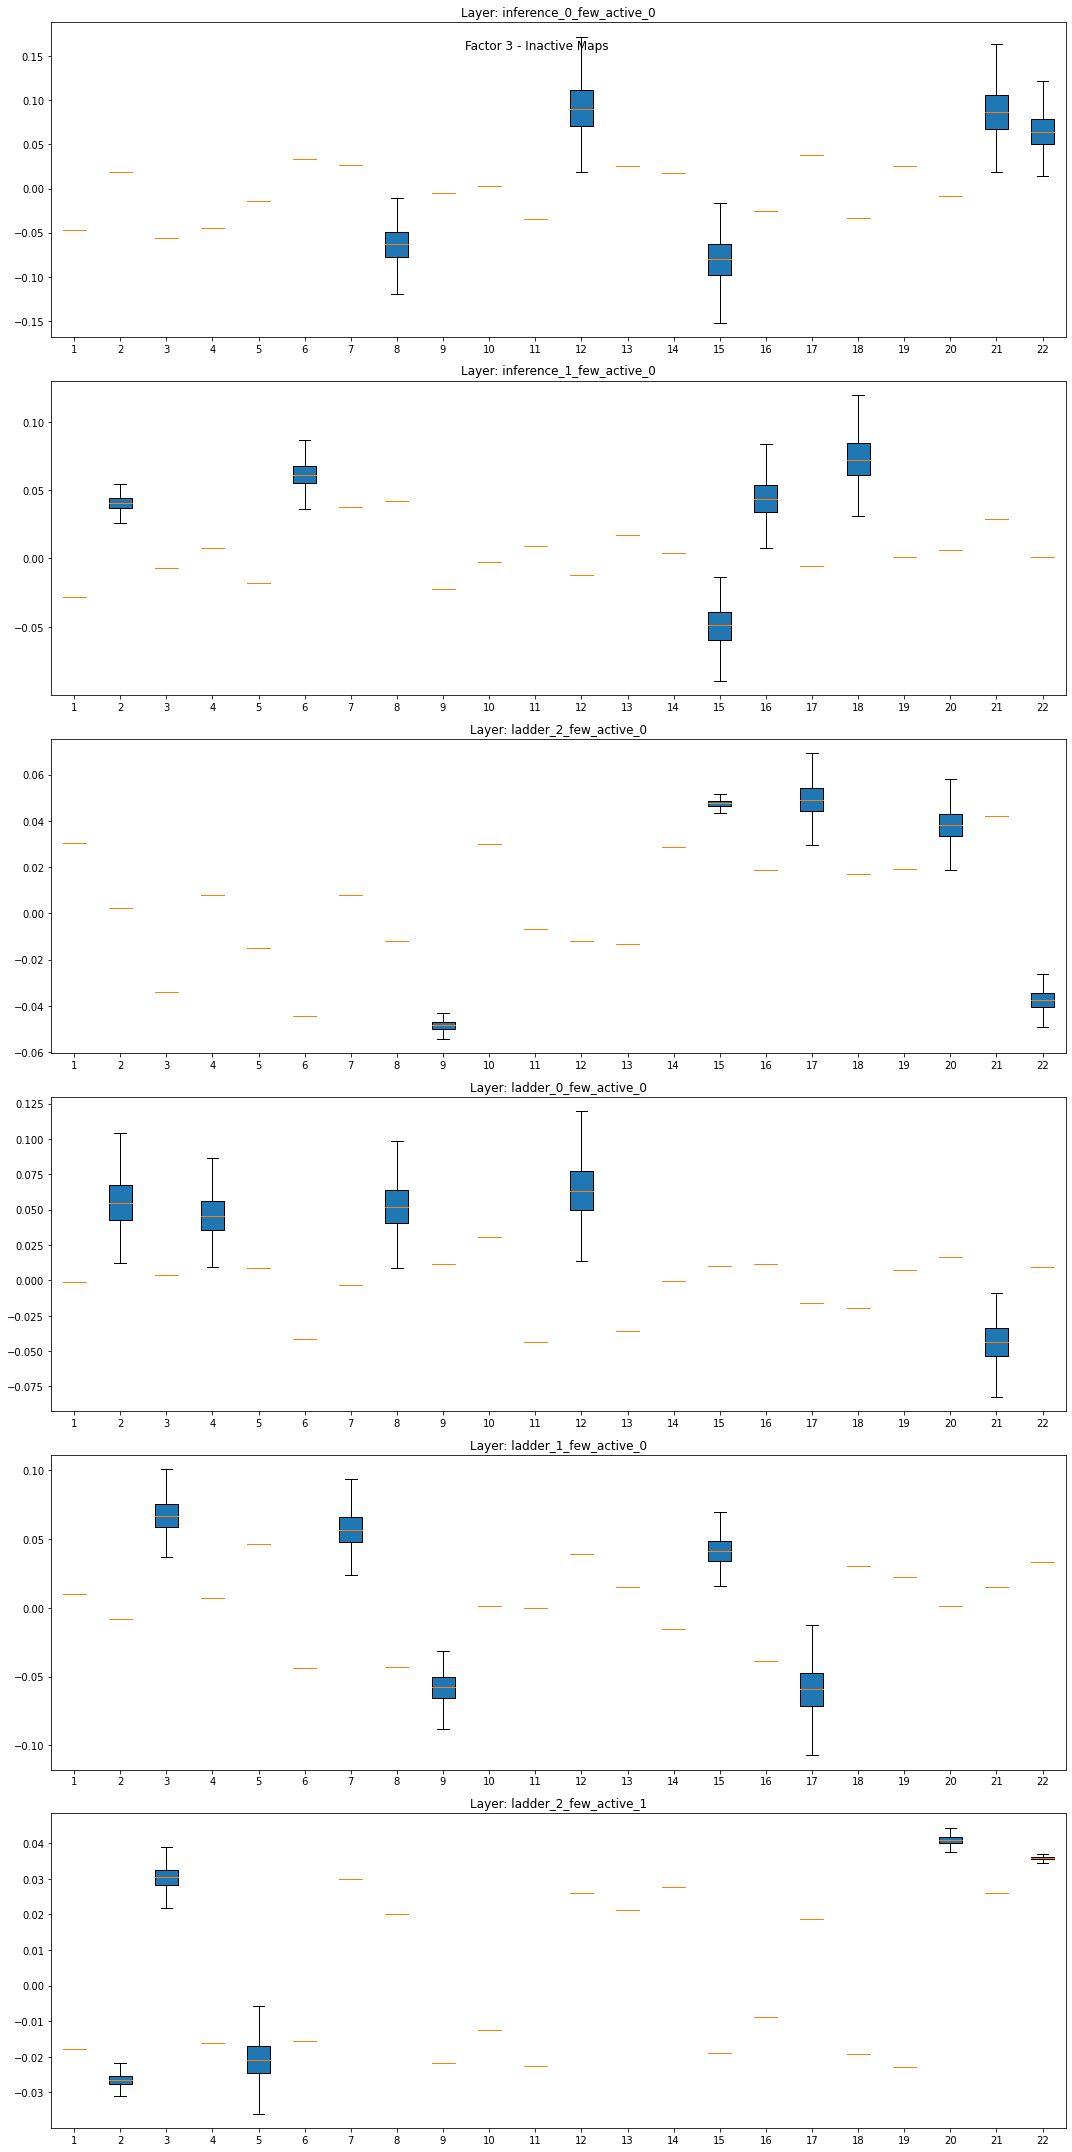

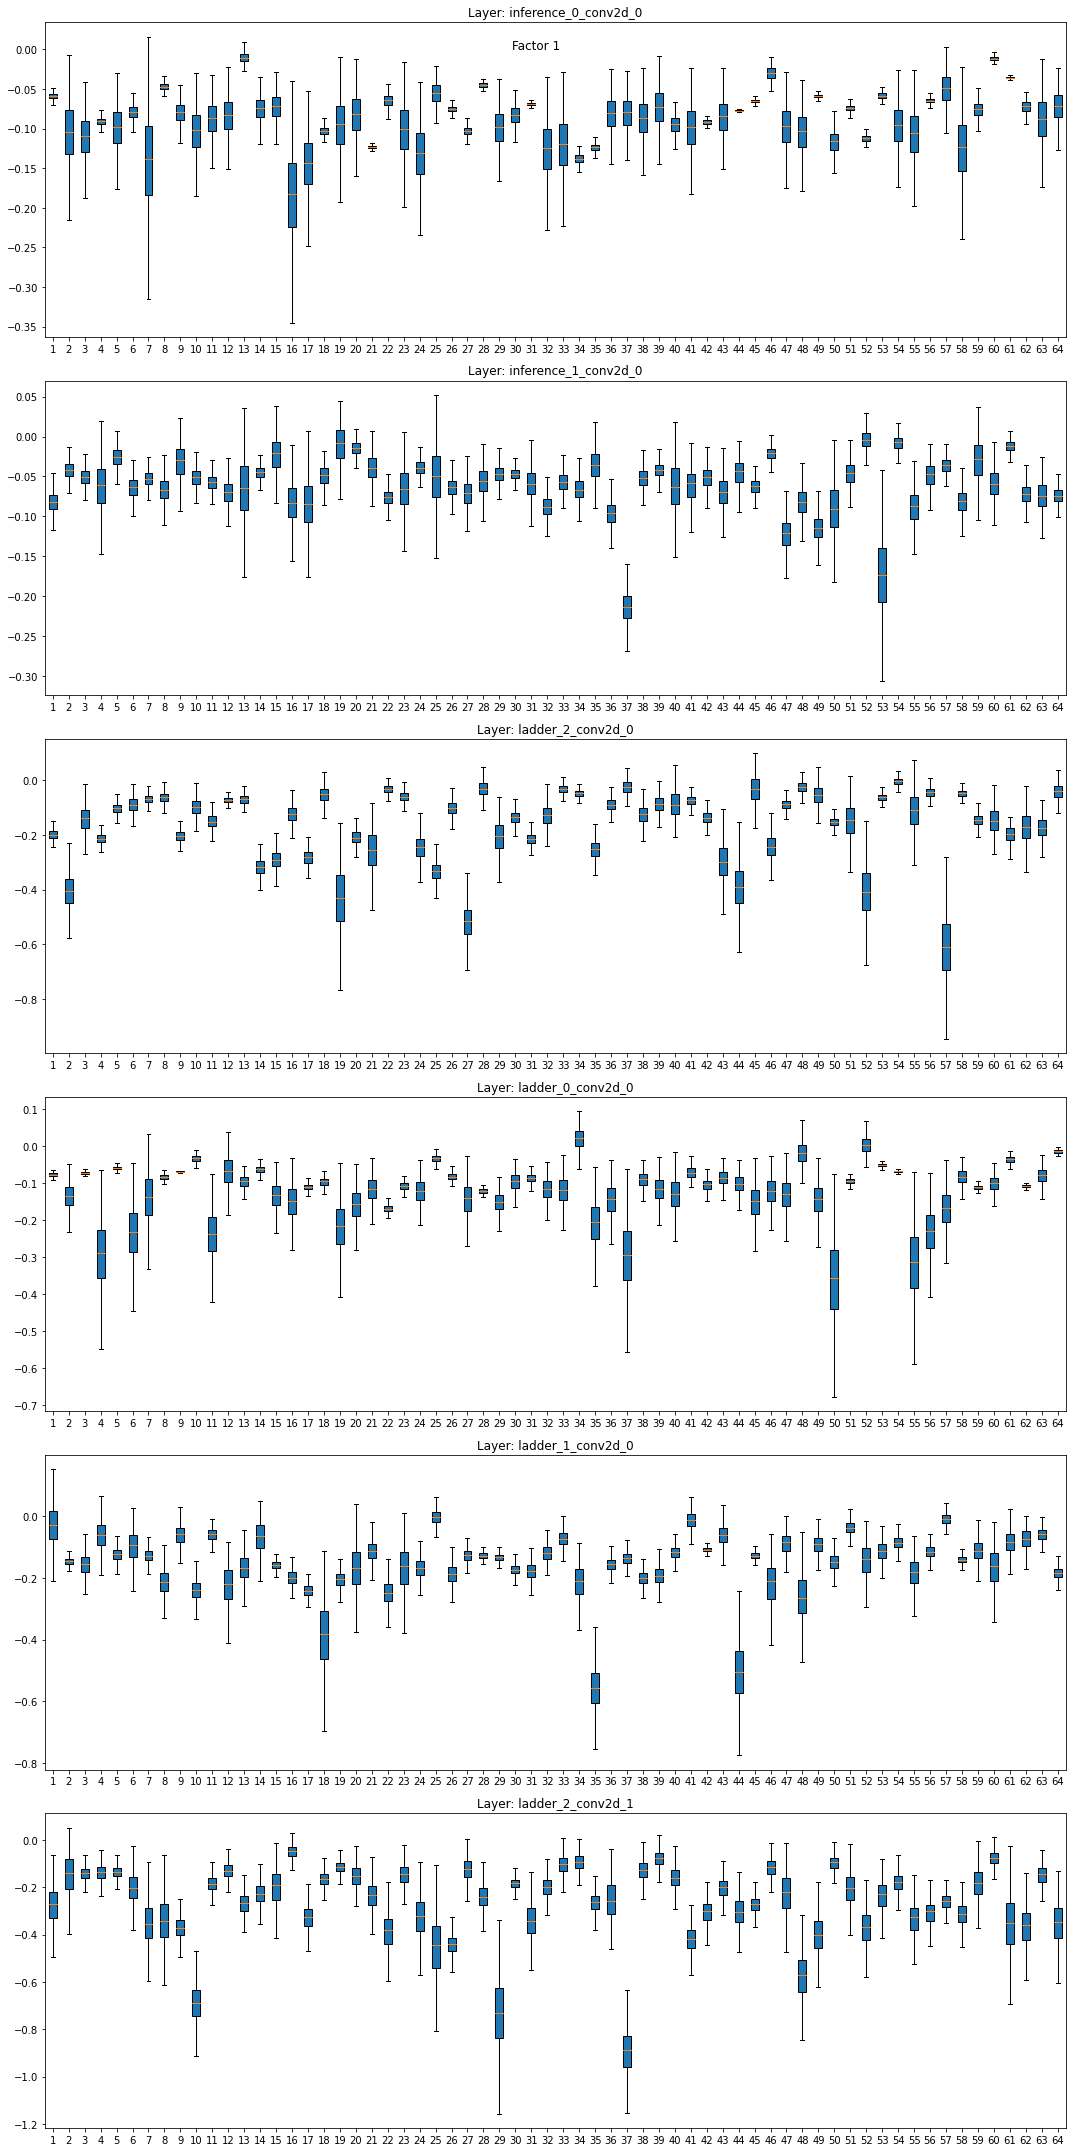

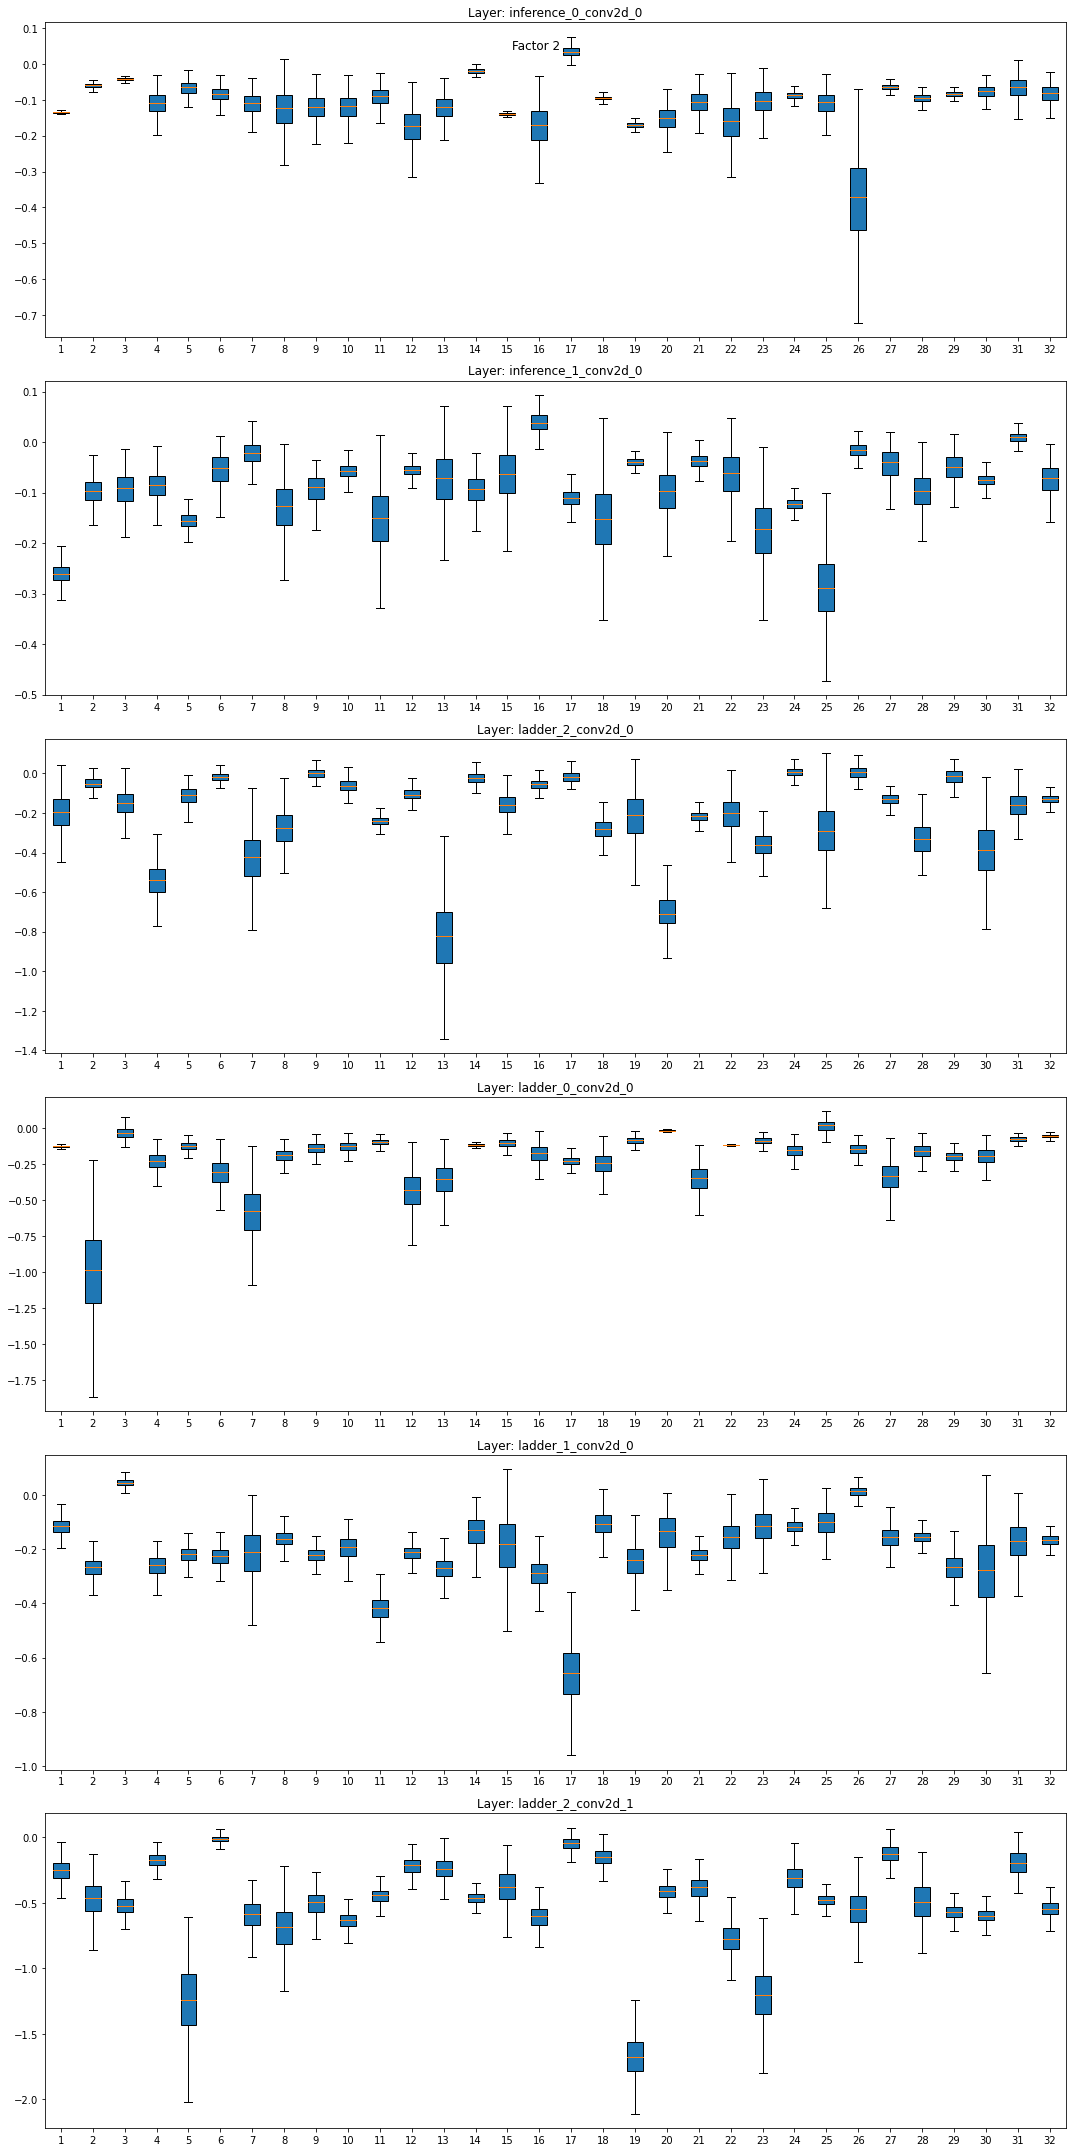

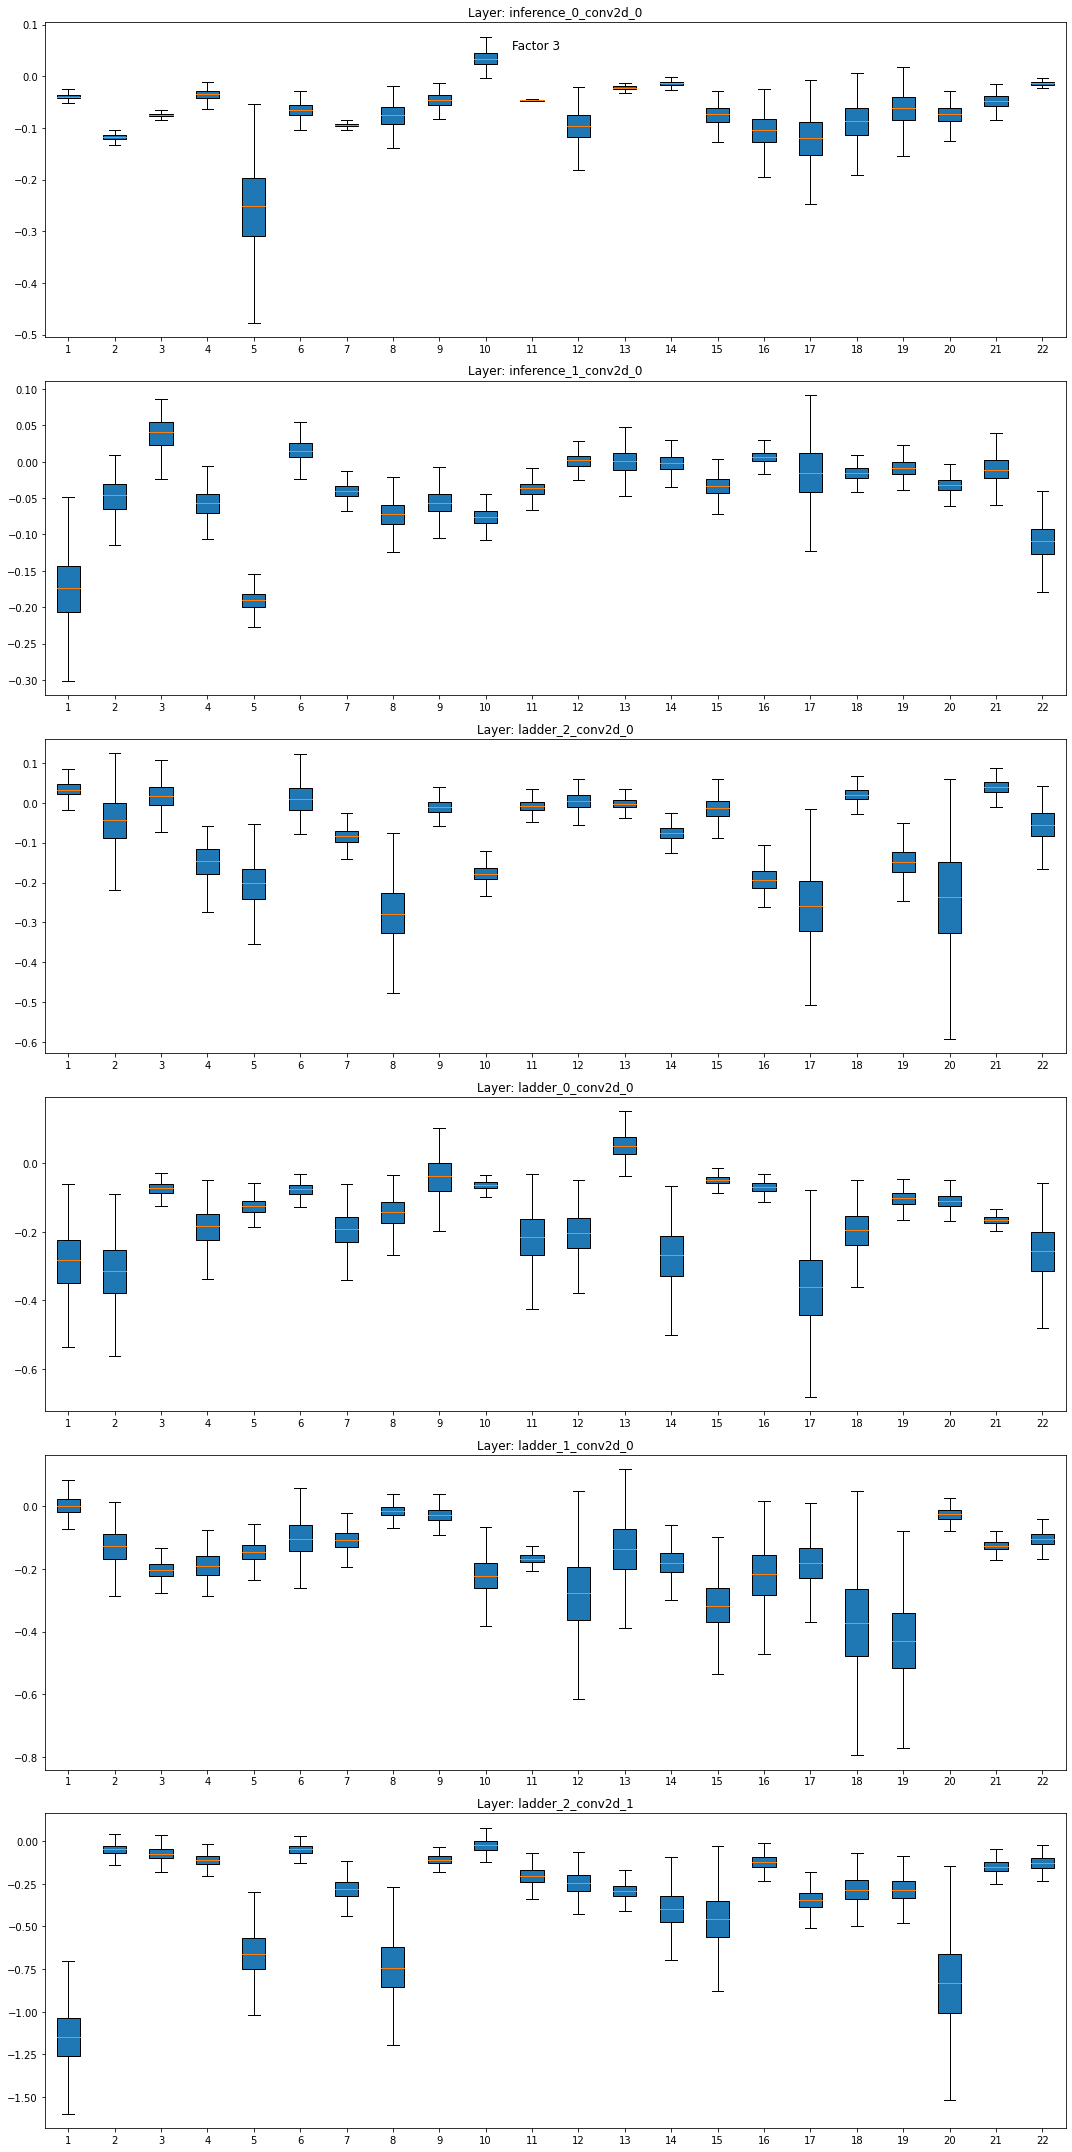

In [128]:
all_keys = list(new_encoders.keys())+ ["Factor 1", "Factor 2", "Factor 3"]
all_values = list(new_encoders.values()) + [vlae_fm1.encoder, vlae_fm2.encoder, vlae_fm3.encoder]

for name, encoder in zip(all_keys, all_values):

    conv_layers = [l for l in encoder.layers if isinstance(l, FewActiveLayer if 'Inactive Maps' in name else Conv2D)]
    multi_output_model = Model(encoder.inputs, [l.output for l in conv_layers])
    preds = multi_output_model.predict(np.expand_dims(x_val[:9984] / 255.0, -1))
    fig, axs = plt.subplots(ncols = 1, nrows = len(conv_layers), figsize = (15,5*len(conv_layers)))
    fig.suptitle(name)
    for i, layer in enumerate(conv_layers):
        activies = np.mean(preds[i], axis=(1,2))

        num_fms = activies.shape[-1]


        ax = axs[i]

        ac_max, ac_min = np.max(activies), np.min(activies)

        ax.set_title(f"Layer: {layer.name}")
        ax.boxplot(activies,showfliers=False, patch_artist=True)
    fig.tight_layout()
    plt.show(fig)

In [138]:
def reconstruction_loss(y_true, y_pred):
    return 10000*np.mean(np.square(y_true - y_pred))

In [139]:
import scipy
from sklearn.utils import shuffle
x_val = shuffle(x_val)

num_splits = 24
splits = [x_val[i*(10000//num_splits):(i+1)*(10000//num_splits)] for i in range(num_splits)]


for name, (sparse_encoder, true_encoder), decoder in zip(list(new_encoders.keys()),zip(list(new_encoders.values()), [vlae_fm1.encoder, vlae_fm2.encoder, vlae_fm3.encoder]) , [vlae_fm1.decoder, vlae_fm2.decoder, vlae_fm3.decoder]):
    print(name)
    sparses = []
    trues = []
    for split in splits:
        split_good_format = np.expand_dims(split/255.0, -1)
        sparses.append(reconstruction_loss(split_good_format,decoder.predict(sparse_encoder.predict(split_good_format))))
        trues.append(reconstruction_loss(split_good_format,decoder.predict(true_encoder.predict(split_good_format))))
    print(scipy.stats.wilcoxon(sparses, trues))
    print(f"Mean sparses: {np.mean(sparses)}")
    print(f"STD Sparses: {np.std(sparses)}")
    print(f"Mean trues: {np.mean(trues)}")
    print(f"STD trues: {np.std(trues)}")

Factor 1 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 1190.6161134126492
STD Sparses: 14.710411185639423
Mean trues: 232.75950364274786
STD trues: 8.13584297823115
Factor 2 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 1111.33668220087
STD Sparses: 16.32597431621047
Mean trues: 208.10743147573484
STD trues: 6.9579304874548304
Factor 3 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 1106.5441897904084
STD Sparses: 13.941611187499067
Mean trues: 200.25800452107305
STD trues: 6.822384738141925


In [134]:
for

24

In [123]:
a = FewActiveLayer([1,2], np.random.standard_normal(100))

top_argmax(np.array([1,2,3,4,5,6,7,8,9,10,11], dtype=np.float32), 5)

[10, 9, 8, 7, 6]

In [125]:
a.inactive_idxs

array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])